In [5]:
# Load unet_epoch_31.pth and final_train_data.pkl and process the data to create a submission file.
import torch
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from dataextractor import load_zipped_pickle
from model import UNet

def load_unet_model(checkpoint_path, device='cuda'):
    """Load the pre-trained UNet model."""
    model = UNet(in_channels=1, out_channels=1).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

def predict_on_test_frames(model, test_frames, original_shapes, device='cuda'):
    """Predict binary masks for the test frames using the UNet model."""
    predictions = []
    for frame, original_shape in tqdm(zip(test_frames, original_shapes), total=len(test_frames)):
        # Preprocess the frame
        frame_normalized = (frame.astype(np.float32) / 255.0 - 0.5) / 0.5  # Normalize to match training
        frame_tensor = torch.tensor(frame_normalized).unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, H, W]

        # Predict the mask
        with torch.no_grad():
            pred_mask = model(frame_tensor)  # Raw model output
            pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()  # Apply sigmoid and remove batch/channel dims

        # Threshold to create a binary mask
        # binary_mask = (pred_mask > 0.8).astype(np.uint8)  # Threshold at 0.5

        # Resize to the original frame shape if necessary
        resized_mask = cv2.resize(pred_mask, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)
        predictions.append(resized_mask)
    
    return predictions


In [6]:
# Load processed test data
test_names, test_frames = load_zipped_pickle('final_test_data.pkl')

# Save the original shapes of the test frames
original_shapes = [frame.shape for frame in test_frames]

# Load the UNet model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
unet_model = load_unet_model('checkpoints/unet_epoch_46.pth', device=device)

# Predict binary masks
binary_masks = predict_on_test_frames(unet_model, test_frames, original_shapes, device=device)

C:\Users\GiantStingray\AppData\Local\Temp\ipykernel_15012\2142584694.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_locati

[[0.500032   0.5000546  0.50006884 ... 0.5001562  0.5001694  0.50006574]
 [0.5000611  0.5001094  0.50017947 ... 0.50017947 0.5001692  0.50016224]
 [0.5000978  0.50018364 0.50016755 ... 0.5001728  0.50013465 0.5001879 ]
 ...
 [0.50007606 0.50015104 0.500115   ... 0.5001355  0.5001323  0.5001823 ]
 [0.5000805  0.5001462  0.5001443  ... 0.5001377  0.5001093  0.5001538 ]
 [0.5000427  0.5000692  0.50006324 ... 0.5001728  0.50014675 0.5000718 ]]


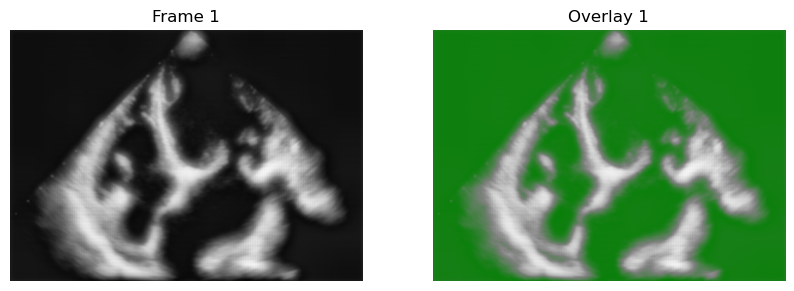

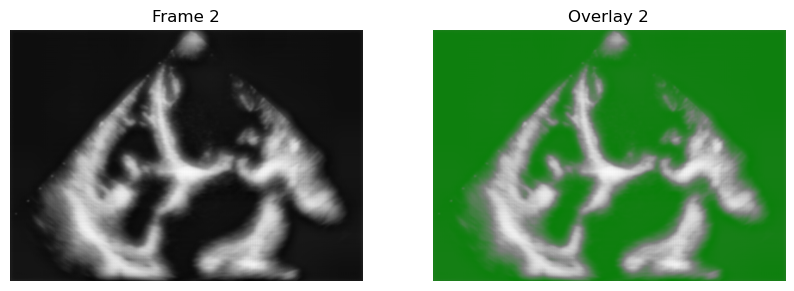

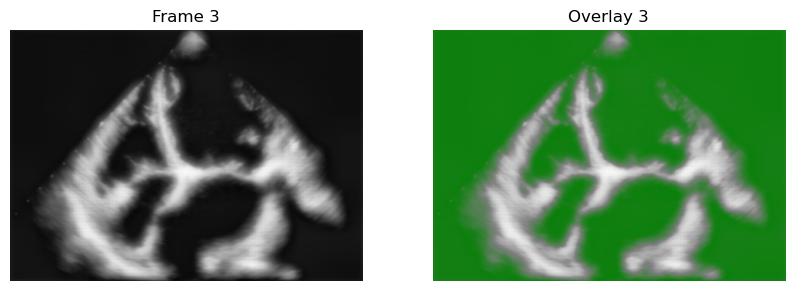

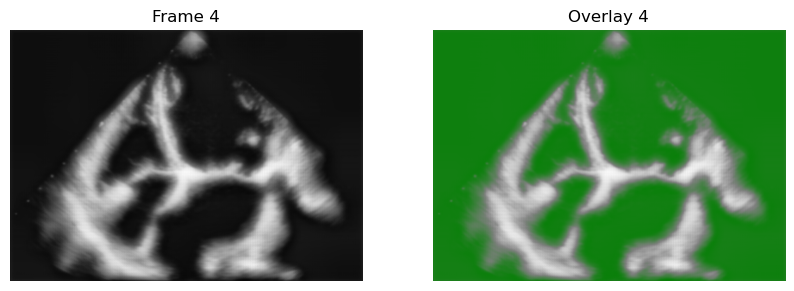

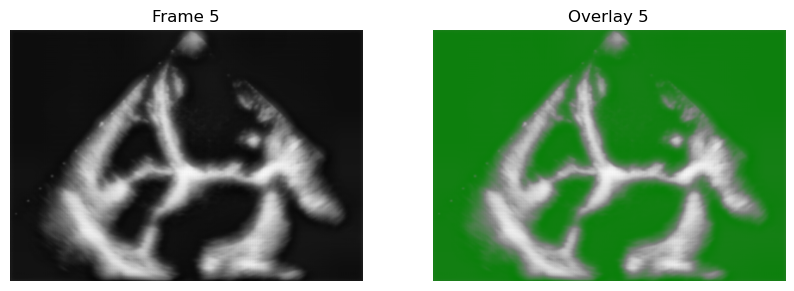

In [10]:
# Display the numerical values of the first mask
print(binary_masks[0])
import matplotlib.pyplot as plt

# Overlay the mask onto the corresponding test frames and display 5 examples
for i in range(5):
    frame = test_frames[i]
    mask = binary_masks[i]

    # Normalize the frame for display
    frame_normalized = (frame - frame.min()) / (frame.max() - frame.min())

    # Create an overlay by combining the frame and mask
    overlay = np.dstack((frame_normalized, frame_normalized, frame_normalized))
    overlay[:, :, 1] = np.maximum(overlay[:, :, 1], mask)  # Add mask to the green channel

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Frame {i+1}")
    plt.imshow(frame, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Overlay {i+1}")
    plt.imshow(overlay)
    plt.axis('off')

    plt.show()

In [11]:
from dataextractor import preprocess_test_data
_, test_frames = preprocess_test_data()

100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


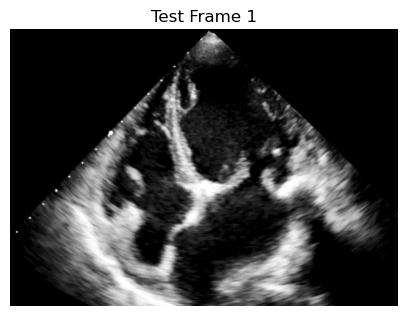

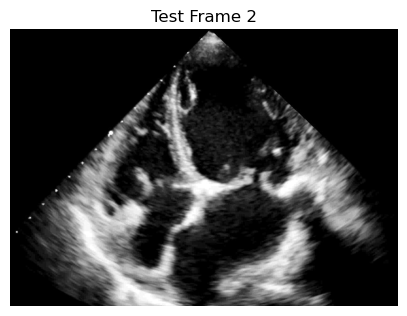

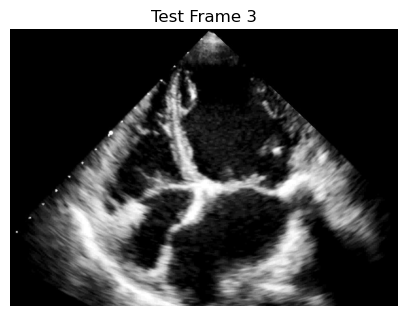

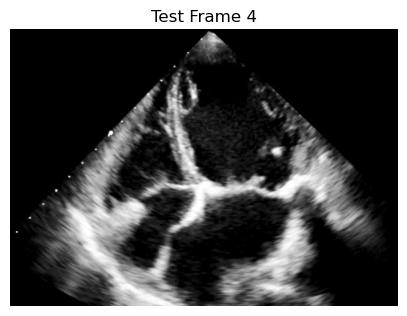

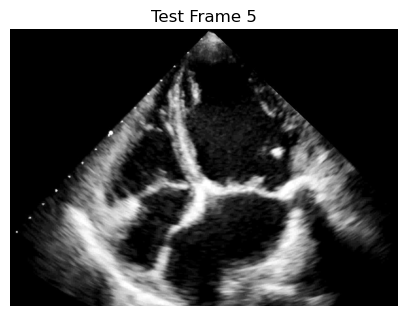

In [12]:
import matplotlib.pyplot as plt

# Display the first 5 test frames
for i in range(5):
    frame = test_frames[i]
    
    plt.figure(figsize=(5, 5))
    plt.title(f"Test Frame {i+1}")
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.show()